In [1]:
!pip install segmentation_models_pytorch
import os
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import albumentations as A  
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as TF
import segmentation_models_pytorch as smp
from IPython.display import clear_output
import cv2
from torchvision import transforms
import copy

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import time
import math

clear_output() 

In [2]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# параметры обучения
LEARNING_RATE = 3e-4
BATCH_SIZE    = 16 # 64
NUM_EPOCHS    = 5
STEP_SIZE = 100
GAMMA = 0.6

# Размеры картинки на вход в модель
IMAGE_HEIGHT  = 384  
IMAGE_WIDTH   = 384

# путь для загрузи модели
MODEL_DETECTION_NAME = '/kaggle/input/jewellery/models/model_jew_detect_01.05.2023.md'
MODEL_MASK_NAME = '/kaggle/input/jewellery/models/model_jew_mask_13.05.2023v2.md'

INPUT_TRANSPARENT_DIR = '/kaggle/input/jewellery/raw_data_all/raw_data_all'
AAA_PATH  = '/kaggle/input/jewellery/aaa-jewellery-images/aaa-jewellery-images'


cuda


In [4]:
def load_model_detection(name):
    '''
    Загрузка модели детектции

    :param name: путь к файлу модели детектции
    :return: модель
    '''
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)    
    
    num_classes = 2 
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
      
    model.to(DEVICE)
    return model

In [5]:
def load_model_mask(name):
    '''
    Загрузка модели сегментации

    :param name: путь к файлу модели сегментации
    :return: модель
    '''    
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(name))
    else:    
        model.load_state_dict(torch.load(name, map_location=torch.device('cpu')))
        
    params = [p for p in model.parameters() if p.requires_grad]        
   
    model.to(DEVICE)

    return model

In [6]:
model_detection = load_model_detection(MODEL_DETECTION_NAME)
model_mask = load_model_mask(MODEL_MASK_NAME)
clear_output() 

In [7]:
model_detection.eval()
model_mask.eval()
print()

In [8]:
def draw_box_on_image(image:Image, x0:int, y0:int, x1:int, y1:int, color='green'):
    '''
    Выводит изображение с нанесенной detection box
    
    :param image: изображение типа PIL Image
    :param x0: x координата левого верхнего угла
    :param y0: y координата левого верхнего угла
    :param x1: x координата правого нижнего угла
    :param y1: y координата правого нижнего угла
    :param color: цвет рамки
    :return: Выводит изображение с нанесенной detection box
    '''        
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box    

In [9]:
def draw_box_on_image(image:Image, x0:int, y0:int, x1:int, y1:int, color='green'):
    '''
    Выводит изображение с нанесенной detection box
    
    :param image: изображение типа PIL Image
    :param x0: x координата левого верхнего угла
    :param y0: y координата левого верхнего угла
    :param x1: x координата правого нижнего угла
    :param y1: y координата правого нижнего угла
    :param color: цвет рамки
    :return: Выводит изображение с нанесенной detection box
    '''        
    show_box = copy.copy(image)
    draw=ImageDraw.Draw(show_box)
    draw.rectangle([(x0, y0),(x1, y1)],outline=color, width=3)
    return show_box    

In [10]:
def draw_image_with_box(image:Image):
    '''
    Выводит изображение с  нанесенной detection box
    
    :param image: изображение типа PIL 
    :return: Выводит изображение с нанесенной detection box
    '''      
    x0, y0, x1, y1 = get_box_from_rgba(image)       
    return draw_box_on_image(image, x0, y0, x1, y1)

In [11]:
def get_random_images(dir_images, n=2):
    '''
    Импортирует n случайных изображений из папки dir_images
    
    :param dir_images: папка 
    :param n: количесто изображений     
    :return: Выводит список изображений PIL Image из n штук
    '''         
    images_in_dir = os.listdir(dir_images)    
    image_names = random.sample(images_in_dir, n)
    
    image_list = []
    
    for name in image_names:
        img_path_image = os.path.join(dir_images, name)   
        image = Image.open(img_path_image)
        image_list.append(image)
    return image_list      

In [12]:
def PIL_image_to_tensor(image, model_shape):
    '''
    Преобразует изображение PIL Image в нормализованное и изменяет размеры на model_shape

    :param image: изображение PIL Image
    :param model_shape: новые размеры изображения
    :return: PIL Image нормализованное размера model_shape
    '''    
    test_transform = torch.nn.Sequential(    
        transforms.Resize(model_shape),    
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        )       
    
    image = TF.to_tensor(image)    
    image = test_transform(image)
    return image  
    
    
def PIL_images_to_tensors(images, model_shape):
    '''
    Преобразует image формата PIL_image в нормализованный тензор размера model_shape

    :param images: изображение PIL_image
    :param model_shape: новые размеры изображения
    :return: тензор размером model_shape
    '''    
    images = [i.convert('RGB') for i in images]
    return [PIL_image_to_tensor(i, model_shape=model_shape) for i in images]   

In [13]:
def jewellery_detection_get_rx_ry(images, model, model_shape=(384, 384), k=0):
    '''
    Делает детекцию объектов. Выдает относительные координаты
    :param images: список PIL Image изображения - желательно делать маленькими батчами
    :param model: model for detection
    :param model_shape: shape of images in model
    :return" relative coordinates (i.e. coordinate devide dimenstion of image) 
            of detection box in a format (x1, y1, x2, y1)
    '''
    model.eval()   
    
    aug_image = PIL_images_to_tensors(images, model_shape=model_shape)
    aug_image = list(image.to(DEVICE) for image in aug_image)    
    model.to(DEVICE)
    predictions = model(aug_image)
    
    result =[]    
    
    for i, prediction in enumerate(predictions):    
    
        pred_boxs = prediction['boxes']
        pred_boxs_numpy = pred_boxs.detach().cpu().numpy()
        
        pred_scores = prediction['scores']
        pred_score = pred_scores[0].item()

        pred_scores_numpy = pred_scores.detach().cpu().numpy()

        
        for threshold in [0.8, 0.7, 0.6, 0.5]:
            list_ind = np.where(pred_scores_numpy > 0.8)[0]
            ind_max = len(list_ind)
            if ind_max > 0:
                break
        if ind_max == 0:
            ind_max = 1

        pred_boxs_good = pred_boxs_numpy[:ind_max]

        best_x1 = min([p[0] for p in pred_boxs_good])
        best_y1 = min([p[1] for p in pred_boxs_good])
        best_x2 = max([p[2] for p in pred_boxs_good])
        best_y2 = max([p[3] for p in pred_boxs_good])    

        rx1 = best_x1 / model_shape[0]
        ry1 = best_y1 / model_shape[1]
        rx2 = best_x2 / model_shape[0]
        ry2 = best_y2 / model_shape[1]   

        if k > 0:
            rx1 = max(rx1 - k, 0)
            rx2 = min(rx2 + k, 1)        
            ry1 = max(ry1 - k, 0)
            ry2 = min(ry2 + k, 1)

        result.append(((rx1, ry1, rx2, ry2), pred_score))
        
    return result  

In [14]:
images_original = get_random_images(AAA_PATH, n=4)

In [15]:
rboxes = jewellery_detection_get_rx_ry(images_original, model_detection, k=0.02)    

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
def crop_image(image, rbox):
    '''
    Обрезка изображения

    :param image: изображение
    :param rbox: список относительных координат
    :return: обрезанное изображение
    '''    
    image_shape = image.size      
    x1 = image_shape[0] * rbox[0]
    y1 = image_shape[1] * rbox[1]
    x2 = image_shape[0] * rbox[2]
    y2 = image_shape[1] * rbox[3]     
    return image.crop((x1, y1, x2, y2))

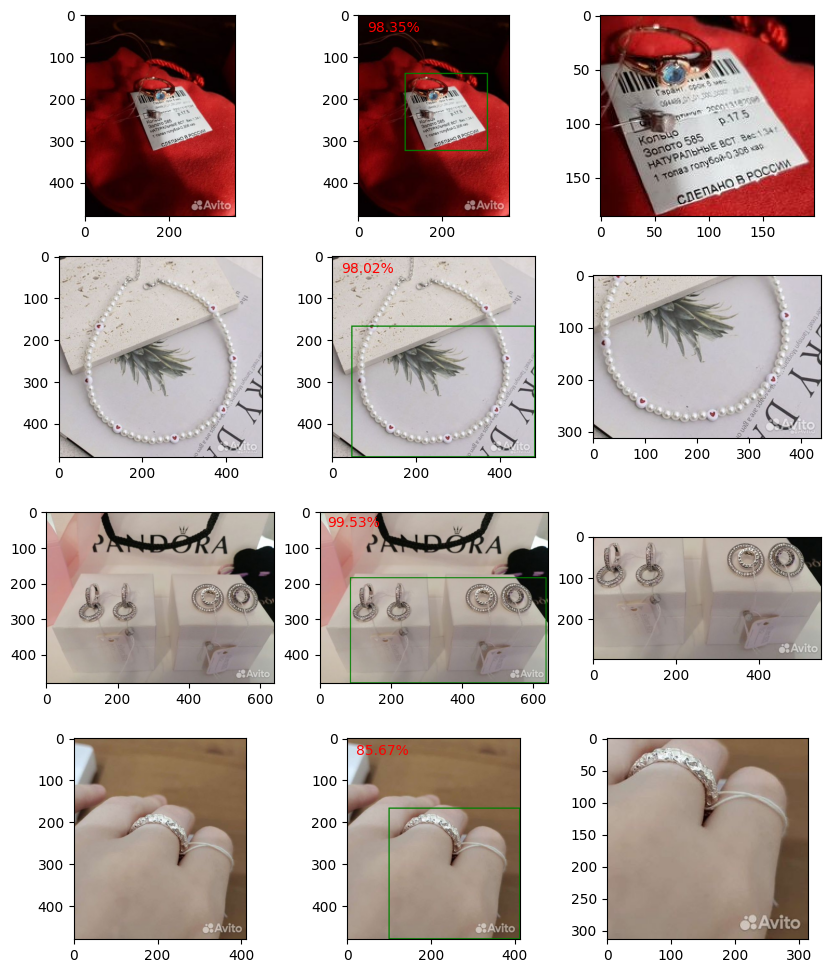

In [17]:
rows = len(rboxes)
_, ax = plt.subplots(rows, 3, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    rbox, acc = rboxes[k]
    image_shape = images_original[k].size   
    
    x1 = image_shape[0] * rbox[0]
    y1 = image_shape[1] * rbox[1]
    x2 = image_shape[0] * rbox[2]
    y2 = image_shape[1] * rbox[3]
    
    image_with_box = draw_box_on_image(images_original[k], x1, y1, x2, y2, color='green')        
        
    ax[k][1].imshow(image_with_box)    
    ax[k][1].text(20,40, f'{acc:.2%}', color='red')

    ax[k][2].imshow( crop_image(images_original[k], rbox) )    

In [18]:
def jewellery_mask(images, model, model_shape=(384, 384), k=0):
    '''
    Инференс модели по обределению маски

    :param images: исходные изображения формата PIL Image
    :param model: модель
    :param model_shape: размер изобржанения на входе в модель
    :return: маска
    '''    
    transform = transforms.ToPILImage()
    
    model.eval()   
    
    aug_image = PIL_images_to_tensors(images, model_shape=model_shape)
    aug_image = list(image.to(DEVICE) for image in aug_image)    
    model.to(DEVICE)
    predictions = model(aug_image)
    
    result =[]   
    
    for i, prediction in enumerate(predictions):           

        pred_box = prediction['boxes'][0].tolist()
        pred_score = prediction['scores'][0].item()
        pred_mask = transform(prediction['masks'][0])        
        
        result.append((pred_mask, pred_score))
    return result   

In [19]:
masks = jewellery_mask(images_original, model_mask)    

In [20]:
def clean_image_with_mask(image, r=0.6, blur=0.1):
    '''
    Обработка маски. Сначала к 1 приравнивается все значения больше r, остальные к 0.
    Оставшиеся к нулю приравниваются.
    После этого происходит размытие маски

    :param image: исходное изображение формата PIL Image
    :param r: порог для округения
    :param min_blur: параметр размытия
    :return: PIL Image
    '''
    
    if r == None:
        return image
    
    image = np.array(image)
    
    x = image[:,:,3] / 255.0+(r-0.5)
    x = np.clip(x, blur, 1)    
    image[:,:,3] = x*255
    
    return Image.fromarray(image)

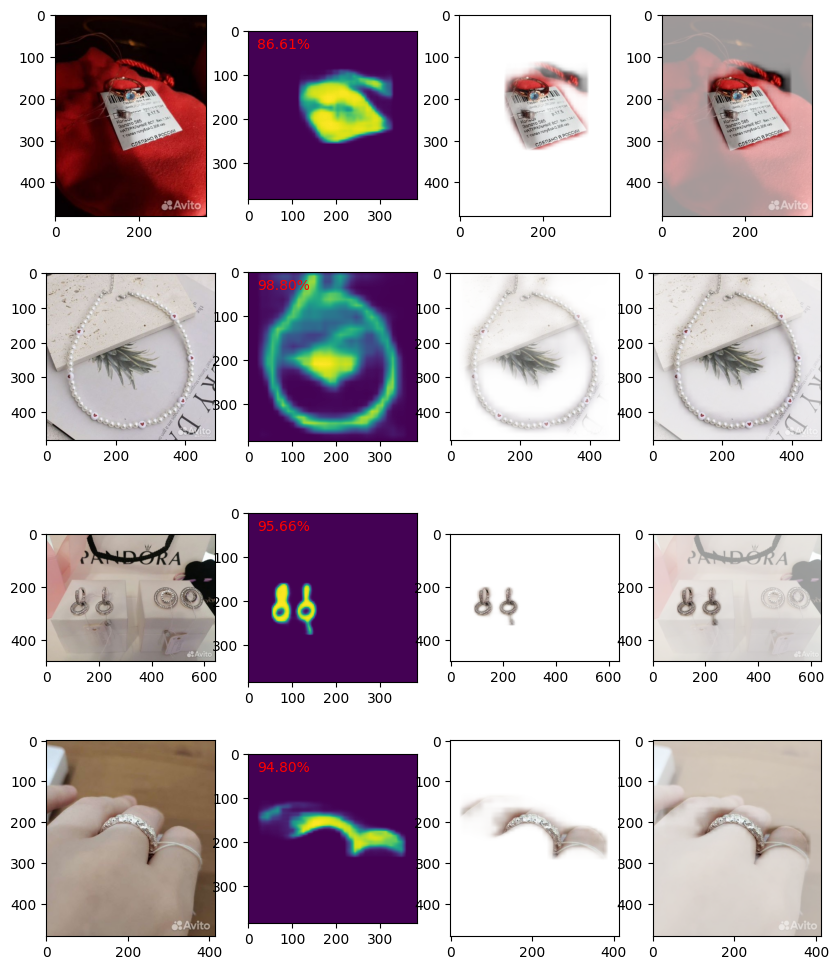

In [21]:
rows = len(masks)
_, ax = plt.subplots(rows, 4, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    mask, acc = masks[k]

    ax[k][1].imshow(mask)    
    ax[k][1].text(20,40, f'{acc:.2%}', color='red')
    
    q = copy.copy(images_original[k])
    q.putalpha(mask.resize(images_original[k].size)  )
    
    ax[k][2].imshow(q)
    
    
    
    q_clean = clean_image_with_mask(q, r=0.9)       
    ax[k][3].imshow(q_clean)

In [22]:
def jewellery_detect_crop_mask(images, model_detection, model_mask, model_shape=(384, 384), k=0):
    '''
    Совместная работа двух моделей. Формирование словаря резултатов на выходе

    :param images: исходные изображения формата PIL Image
    :param model_detection: модель детектции
    :param model_mask: модель сегментации
    :param model_shape: размер изобржанения на входе в модели
    :param k: расширение рамки для детектции на 100*k процентов
    :return: словарь с результатами работы модели
    '''    
    rboxes = jewellery_detection_get_rx_ry(images, model_detection, model_shape=model_shape, k=0.02)   
   
    cropped_images = []
    detect_acc = []

    rows = len(rboxes)    
    for k in range(rows):    
        rbox, acc = rboxes[k]
        cropped_image = crop_image(images_original[k], rbox)
        cropped_images.append(cropped_image)
        detect_acc.append(acc)
            
    masks = jewellery_mask(cropped_images, model_mask)    
    
    result = []
    for k in range(rows):    
        res = {}
        res['cropped_image'] = cropped_images[k]
        res['detection_accurancy'] = detect_acc[k]
        res['mask'] = masks[k][0]
        res['segmentation_accurancy'] = masks[k][1]
        
        result.append(res)        
    
    return result

In [23]:
res = jewellery_detect_crop_mask(images_original, model_detection, model_mask)

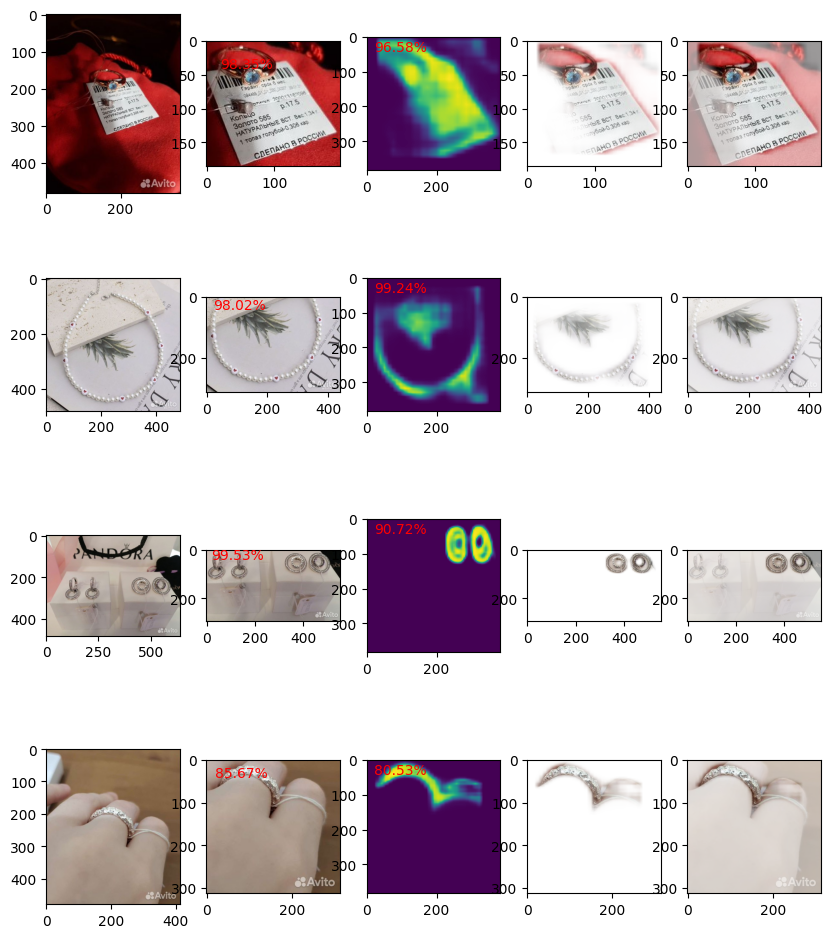

In [24]:
rows = len(res)
_, ax = plt.subplots(rows, 5, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(images_original[k])      
    
    cropped_image = res[k]['cropped_image']
    cropped_image_acc = res[k]['detection_accurancy']    
    ax[k][1].imshow(cropped_image)      
    ax[k][1].text(20,40, f'{cropped_image_acc:.2%}', color='red')

    
    mask = res[k]['mask']
    acc = res[k]['segmentation_accurancy']

    ax[k][2].imshow(mask)    
    ax[k][2].text(20,40, f'{acc:.2%}', color='red')
    
    q = copy.copy(cropped_image)
    q.putalpha(mask.resize(cropped_image.size)  )    # !!!!
    ax[k][3].imshow(q)   
        
    q_clean = clean_image_with_mask(q, r=0.9)       
    ax[k][4].imshow(q_clean) 

In [25]:
def get_jewellery_image(images_original, 
                        model_detection, 
                        model_mask, 
                        model_shape=(384, 384), 
                        k=0.05, 
                        threshold_detect=0.98, 
                        threshold_segmentation=0.99,
                        threshold_clean_mask = 0.9,
                        show_bad_results=True,
                       ):
    '''
    Инференс моделе с настройками

    :param images_original: исходные изображения в формате PIL Image
    :param model_detection: модель детектции
    :param model_mask: модель сегментации
    :param model_shape: размер изобржанения на входе в модели
    :param k: расширение рамки для детектции на 100*k процентов
    :param threshold_detect: порог уверенности модели детектции
    :param threshold_segmentation: порог уверенности модели сегментации
    :param threshold_clean_mask: порог для сегментации, свыше которого маска равна 1
    :param show_bad_results: показывать ли плохие результаты
    :return: словарь с результатами работы модели
    '''    
    predict = jewellery_detect_crop_mask(images_original, model_detection, model_mask, model_shape=(384, 384), k=k)
    rows = len(res)
    
    for k in range(rows):
        ax[k][0].imshow(images_original[k])      

        cropped_image = predict[k]['cropped_image']
        cropped_image_acc = predict[k]['detection_accurancy']    

        mask = res[k]['mask']
        acc = res[k]['segmentation_accurancy']

        q = copy.copy(cropped_image)
        q.putalpha(mask.resize(cropped_image.size)  )    
        q_clean = clean_image_with_mask(q, r=threshold_clean_mask)    
        
                
        rgb=q_clean.convert('RGB')
        blurred = rgb.filter(ImageFilter.GaussianBlur(20))
        
        
        q_clean = Image.composite(rgb, blurred, mask.resize(cropped_image.size) )
                
        predict[k]['image_segmented'] = q_clean
        
        if predict[k]['detection_accurancy'] < threshold_detect and not show_bad_results:
            predict[k]['cropped_image'] = None
            
        if predict[k]['segmentation_accurancy'] < threshold_detect and not show_bad_results:
            predict[k]['image_segmented'] = None  
            
        predict[k]['image_original'] = images_original[k]  
        
    return predict

In [26]:
res = get_jewellery_image(images_original, model_detection, model_mask, 
                        k=0.05, 
                        threshold_detect=0.9, 
                        threshold_segmentation=0.99,
                        threshold_clean_mask = 0.9,
                        show_bad_results=False,
                       )

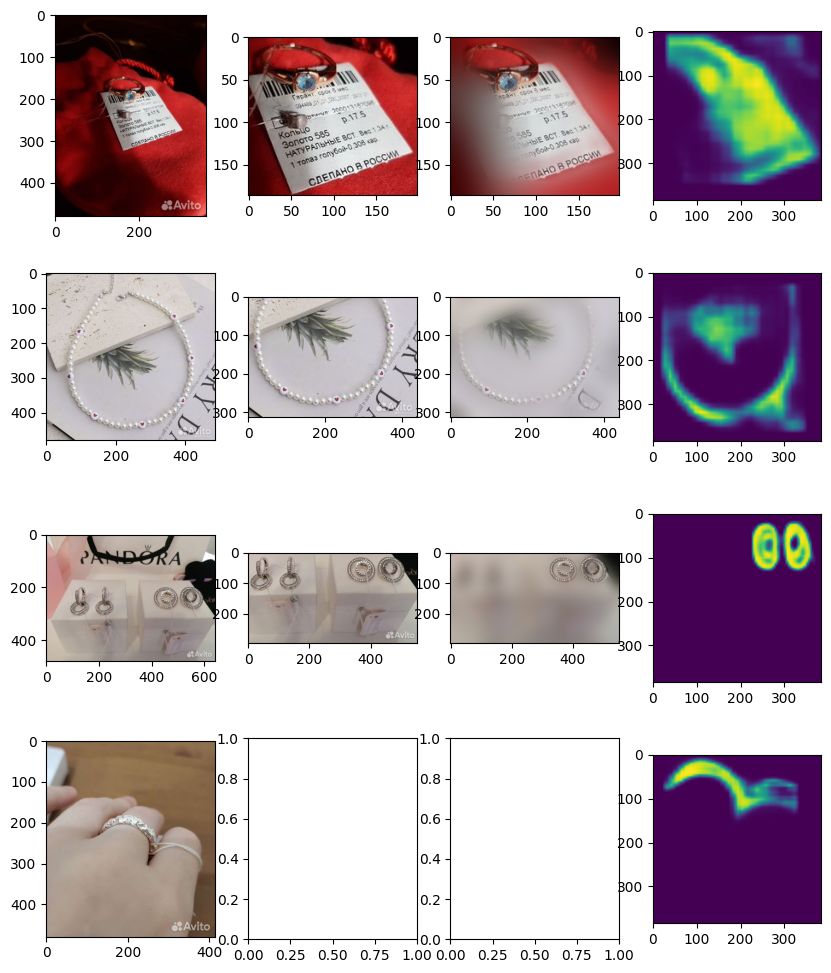

In [27]:
rows = len(res)
_, ax = plt.subplots(rows, 4, figsize=(10,3*rows))

for k in range(rows):
    ax[k][0].imshow(res[k]['image_original'])      
    
    if res[k]['cropped_image'] is not None:
        ax[k][1].imshow(res[k]['cropped_image']) 
    
    if res[k]['image_segmented'] is not None:
        ax[k][2].imshow(res[k]['image_segmented'])        
        
    if res[k]['mask'] is not None:
        ax[k][3].imshow(res[k]['mask'])           